# LIME

In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MNISTデータセット

Text(0.5, 1.0, 'Digit : 5')

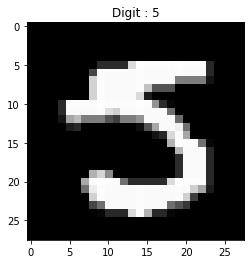

In [2]:
train_data = torchvision.datasets.MNIST(
    root = "../data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root = "../data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["train"])
# 要素を取り出す
imgs, labels = next(batch_iterator)
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(imgs[0].squeeze().numpy(), cmap = "gray")
ax1.set_title(f"Digit : {labels[0]}")

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []
        
        # 1つの入力画像チャンネル、4 x 4の正方形畳み込み、32つの出力チャンネル
        self.Conv1 = nn.Conv2d( 1, 32, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        # 32つの入力画像チャンネル、4 x 4の正方形畳み込み、64つの出力チャンネル
        self.Conv2 = nn.Conv2d(32, 64, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        self.linear1 = nn.Linear(64 * 3 * 3, 128)
        self.linear2 = nn.Linear(128, 10)
        
        # 誤差関数の設定
        self.loss = nn.CrossEntropyLoss() 
        # 最適化手法の設定
        self.optimizer = optim.SGD(self.parameters(), lr = 1e-2)
        
    def forward(self, x):
        x = self.Conv1(x) # Size : 1 x 28 x 28 -> 32 x 14 x 14
        x = torch.relu(x)
        x = self.Conv2(x) # Size : 32 x 14 x 14 -> 64 x 7 x 7
        x = torch.relu(x)
        x = F.max_pool2d(x, 2) # 指定サイズの範囲内で最大の値を抽出する(Size : 64 x 7 x 7 -> 64 x 3 x 3)
        x = x.view(-1, 64 * 3 * 3) # ベクトルに変換
        x = self.linear1(x)
        x = torch.relu(x)
        return self.linear2(x)

# 学習済みモデルの読み込み
model = torch.load("../model/cnn_mnist.pth")

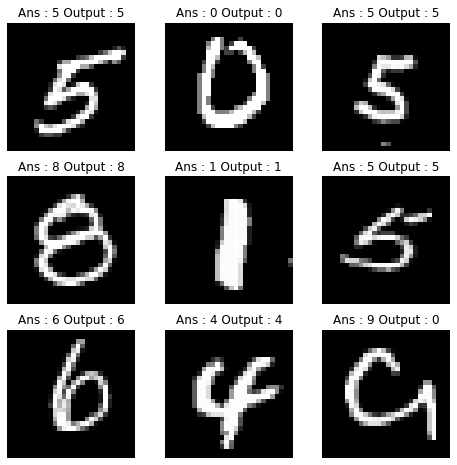

In [4]:
# 推論結果の表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(f"Ans : {label.item()} Output : {model(img).argmax(axis=1).item()}")
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()

In [5]:
def batch_predict(np_rgb_imgs):
    np_imgs = np.zeros((len(np_rgb_imgs), 1, 28, 28))
    for i, np_rgb_img in enumerate(np_rgb_imgs):
        np_imgs[i, 0, :, :] = np_rgb_img[:, :, 0]
    return model(torch.from_numpy(np_imgs).to(torch.float32)).detach().numpy()


imgs, labels = next(iter(dataloaders_dict["test"]))
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image = imgs[0].squeeze().numpy(),
                                         classifier_fn = batch_predict, # classification function
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=10000) # number of images that will be sent to classification function

100% 10000/10000 [00:01<00:00, 5106.57it/s]
